In [ ]:
!pip install pytube3

#Install
Install the dependencies needed to turn your video into digestible frames for deep dream and then redownload it at the end.



In [ ]:
#For video processing:
from pytube import YouTube
import os
import shutil
import math
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from os.path import isfile, join
from google.colab import drive 

Install the dependencies for Google's Deep Dream.

In [ ]:
#For implementing Deep Dream
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image

import tensorflow as tf

#Choose video to dreamify
Choose the video you want from youtube. Alternatively, you can download a video to your computer and upload the file when prompted. Simply comment out the code for the method you want to use.

In [ ]:
#To use a YouTube video:
#yt = YouTube('https://www.youtube.com/watch?v=oeLQI-EFff8') #paste any youtube link here
#print('Your video is titled "'+str(yt.title)+'". It is '+str(yt.length)+' seconds long.')
#stream = yt.streams.first()
#video = stream.download() 

#To use a local file on your machine:
from google.colab import files
#videopath = files.upload() #choose the file you wish to upload when prompted 
video = cv2.VideoCapture('video.mp4') #rename according to what is displayed below

#Turn video into frames
Turn your video into frames that will be dreamified individually. Changing the frameRate changes the number of frames captured per second. Humans see around 24 frames per second but keep in mind that each frame takes about a minute to run.

In [ ]:
try: 
      
    # create a folder named data 
    if not os.path.exists('data'): 
        os.makedirs('data') 
  
# if not created then raise error 
except OSError: 
    print ('Error: Creating directory of data') 

vidcap = video

def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        if count < 10: #add zeros so frames will be sorted correctly later
          name="./data/image00"+str(count)+".jpg"
        elif 10 <= count < 100:
          name="./data/image0"+str(count)+".jpg"
        elif 100<=count<1000:
          name="./data/image"+str(count)+".jpg"
        elif count > 10000:
          print('You have too many files. Try a shorter video or slower frame rate unless you want this program to live longer than you.')
        print ('Creating...' + name) 
        cv2.imwrite(name, image)     # save frame as JPG file
    return hasFrames

sec = 0
frameRate = 0.05 #Capture image every 0.25 seconds
fps = 1/frameRate
count=1 #number of frames
success = getFrame(sec)
while success: 
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)

# Release all space and windows once done 
vidcap.release() 
cv2.destroyAllWindows() 
print('Estimated time to dreamify: '+str(count)+' minutes. (Assuming 1 minute per frame)')

Creating..../data/image001.jpg
Creating..../data/image002.jpg
Creating..../data/image003.jpg
Creating..../data/image004.jpg
Creating..../data/image005.jpg
Creating..../data/image006.jpg
Creating..../data/image007.jpg
Creating..../data/image008.jpg
Creating..../data/image009.jpg
Creating..../data/image010.jpg
Creating..../data/image011.jpg
Creating..../data/image012.jpg
Creating..../data/image013.jpg
Creating..../data/image014.jpg
Creating..../data/image015.jpg
Creating..../data/image016.jpg
Creating..../data/image017.jpg
Creating..../data/image018.jpg
Creating..../data/image019.jpg
Creating..../data/image020.jpg
Creating..../data/image021.jpg
Creating..../data/image022.jpg
Creating..../data/image023.jpg
Creating..../data/image024.jpg
Creating..../data/image025.jpg
Creating..../data/image026.jpg
Creating..../data/image027.jpg
Creating..../data/image028.jpg
Creating..../data/image029.jpg
Creating..../data/image030.jpg
Creating..../data/image031.jpg
Creating..../data/image032.jpg
Creating

#Prepare to dream-ify
Use the pre-trained model Inception V3 to dreamify your image. You can customize which layers you activate. There are 11 of these layers in InceptionV3, named 'mixed0' though 'mixed10'. Lower layers respond to lower level features (textures, shapes) while higher layers respond to higher level features (eyes, faces). 

In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

# Maximize the activations of these layers
names = ['mixed3', 'mixed5'] #choose layers here
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

In [ ]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

This function will run the simplest (and fastest) form of deep dream. For a better quality photo with different scaling of patterns, try my other file, deepdreamoctave.

In [ ]:
def run_deep_dream_simple(img, steps=50, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))
    
    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

#Test first image
These functions download the image so it can be processed by deep dream. Use the show function to show the first frame of your video as a test.

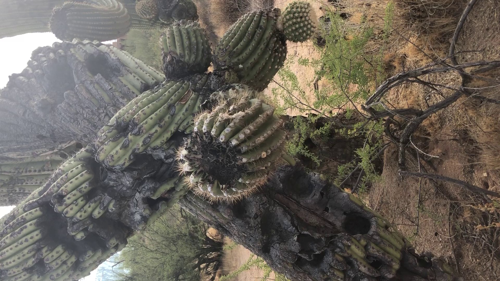

In [ ]:
# Download an image and read it into a NumPy array.
def download(image_path, max_dim=None):
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

  # Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
original_img = download('./data/image002.jpg', max_dim=500)
show(original_img)

#Dreamify each frame
Now we dreamify every frame of the video. WARNING: this cell takes a very long time to run. My laptop takes about 1 minute per frame or less. Play around with different steps and step sizes to get the desired effect.

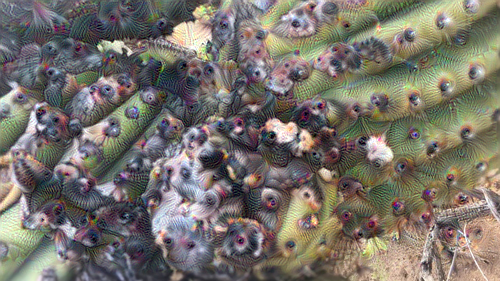

Creating..../data/image155.jpg


In [ ]:
deepdream = DeepDream(dream_model)
for i in range(1,count):
  if i<10:
    imagepath= './data/image00' + str(i) + '.jpg'
  elif 10<=i<100:
    imagepath='./data/image0'+str(i)+'.jpg'
  elif i>=100:
    imagepath='./data/image'+str(i)+'.jpg'
  image = download(imagepath, max_dim=500)
  dream_img = run_deep_dream_simple(img=image, steps=50, step_size=0.01)
  print ('Creating...' + imagepath) 
  cv2.imwrite(imagepath, np.array(dream_img))

# Turn frames into video
Finally, turn your frames back into a video! Change the pathOut to name your video file.

In [ ]:
pathIn = './data/'
pathOut = 'video.avi'


frame_array = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
#for sorting the file names properly
files.sort(key = lambda x: x[5:-4])
files.sort()
frame_array = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
#for sorting the file names properly
files.sort(key = lambda x: x[5:-4])
for i in range(len(files)):
    filename=pathIn + files[i]
    #reading each files
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_array.append(img)
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()

#Download video
Run this block to download your file! Congrats!

In [ ]:
import io
from google.colab import files
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir('./') if isfile(join('./', f))]

for file in onlyfiles:
  if file.startswith(pathOut):
    print(file)
    files.download(file)

dreamifiedbackyardsimple.avi


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

I recommend clearing your data file before moving onto a different video or frame rate. DO NOT RUN IF YOU HAVENT SAVED YOUR VIDEO. This will delete all of the frames in the data folder.

In [ ]:
#!rm -rf data 